In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
p = sns.color_palette()

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train[train['bought'].isnull() ]

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
572,PF00001860,DSK00001794,OFF00001001,A,20070411,NaN,T,0.03864,USD,4.777636,NaN,20070411,NaN,20070514,A,NaN,NaN,0.04632
573,PF00001861,DSK00001795,OFF00001001,A,20070411,NaN,T,0.03864,USD,4.777636,NaN,20070411,NaN,20070514,A,NaN,NaN,0.04632


In [3]:
all_data = train.append(test) 

In [13]:
all_data.shape

(14167, 18)

#### find median sold value from all data with condition below

In [14]:
all_data[(all_data['pf_category'] == 'A') & (all_data['currency'] == 'USD') & (all_data['country_code'] == 'T')]['sold'].median()

72853000.0

#### find median bought value from all data with condition below

In [15]:
all_data[(all_data['pf_category'] == 'A') & (all_data['currency'] == 'USD') & (all_data['country_code'] == 'T')]['bought'].median()

72778203.052744

#### insert median values for sold and bought to train data

In [3]:
train.loc[train['portfolio_id'] == 'PF00001860', 'sold'] = 72853000
train.loc[train['portfolio_id'] == 'PF00001861', 'sold']= 72853000
train.loc[train['portfolio_id'] == 'PF00001860', 'bought'] = 72778203.052744
train.loc[train['portfolio_id'] == 'PF00001861', 'bought'] = 72778203.052744

In [5]:
train[572:574]

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
572,PF00001860,DSK00001794,OFF00001001,A,20070411,72853000.0,T,0.03864,USD,4.777636,7.277820e+07,20070411,NaN,20070514,A,NaN,NaN,0.04632
573,PF00001861,DSK00001795,OFF00001001,A,20070411,72853000.0,T,0.03864,USD,4.777636,7.277820e+07,20070411,NaN,20070514,A,NaN,NaN,0.04632


<IPython.core.display.Javascript object>


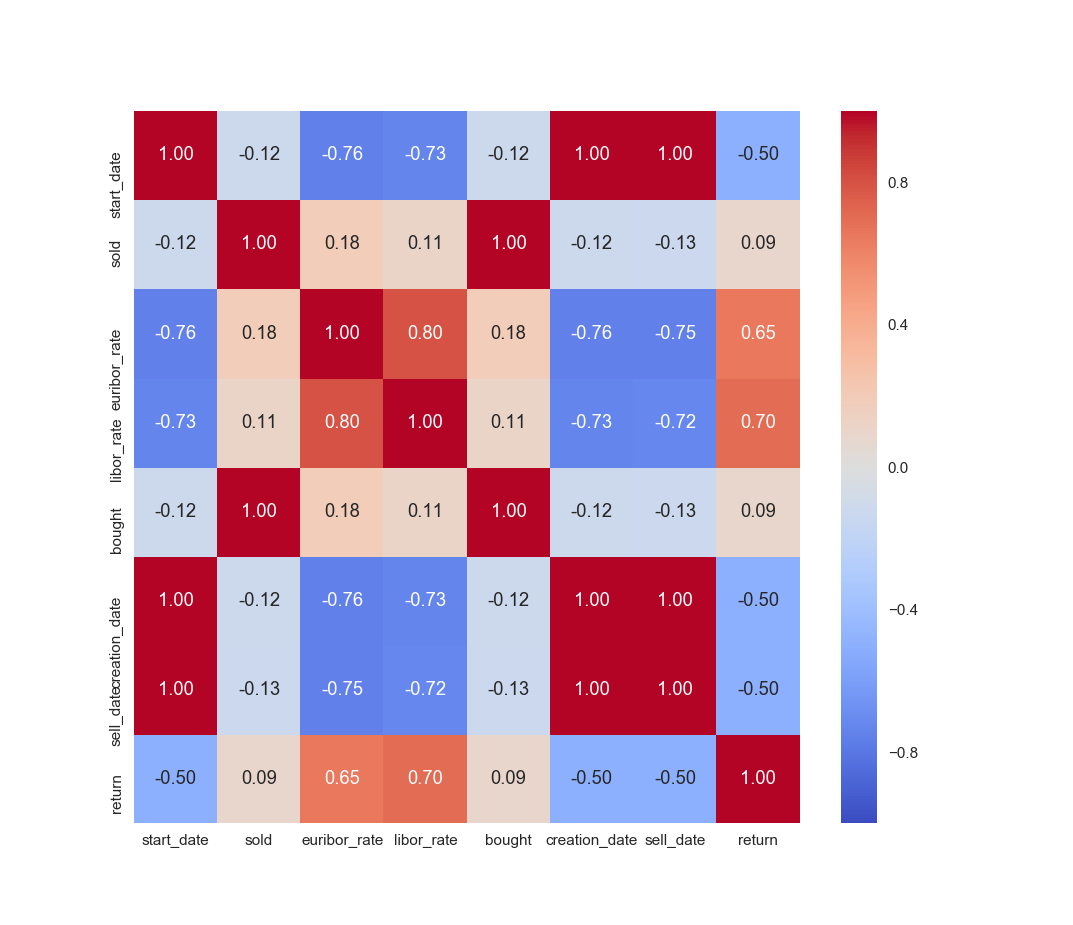

In [6]:
g = sns.heatmap(train[["pf_category","start_date","sold","country_code","euribor_rate", "currency", "libor_rate", "bought", "creation_date", "indicator_code", "sell_date", "type", "hedge_value", "status", "return" ]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [4]:
temp_train = pd.read_csv('train.csv')
temp_test = pd.read_csv('test.csv')

In [5]:
temp_train.loc[train['portfolio_id'] == 'PF00001860', 'sold'] = 72853000
temp_train.loc[train['portfolio_id'] == 'PF00001861', 'sold']= 72853000
temp_train.loc[train['portfolio_id'] == 'PF00001860', 'bought'] = 72778203.052744
temp_train.loc[train['portfolio_id'] == 'PF00001861', 'bought'] = 72778203.052744

In [6]:
obj_cols = ["pf_category", "country_code", "currency", "indicator_code", "type", "hedge_value", "status"]
encoder = LabelEncoder()
for x in obj_cols:
    mask_temp_train = ~temp_train[x].isnull()
    mask_temp_test = ~temp_test[x].isnull()
    encoder.fit(temp_train[x][mask_temp_train])
    temp_train[x][mask_temp_train] = encoder.transform(temp_train[x][mask_temp_train])
    temp_test[x][mask_temp_test] = encoder.transform(temp_test[x][mask_temp_test])
    print(x)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


pf_category
country_code
currency
indicator_code
type
hedge_value
status


In [7]:
temp_train[obj_cols] = temp_train[obj_cols].apply(pd.to_numeric, errors='ignore')
temp_test[obj_cols] = temp_test[obj_cols].apply(pd.to_numeric, errors='ignore')

<IPython.core.display.Javascript object>


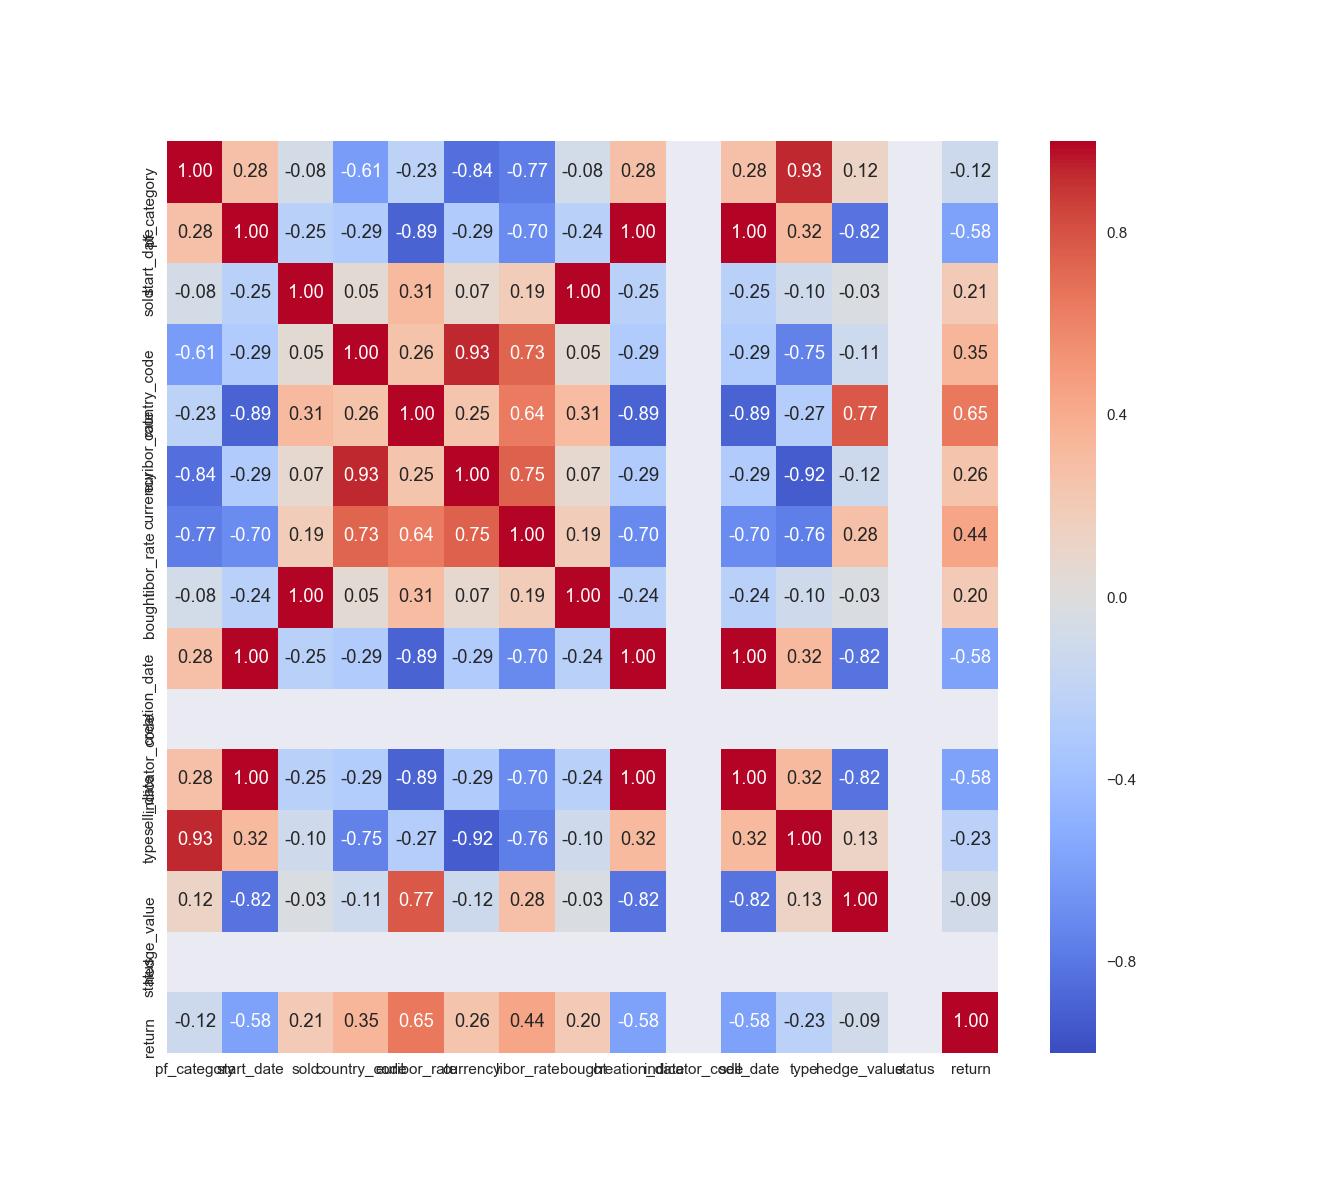

In [8]:
g1 = sns.heatmap(temp_train[["pf_category","start_date","sold","country_code","euribor_rate", "currency", "libor_rate", "bought", "creation_date", "indicator_code", "sell_date", "type", "hedge_value", "status", "return" ]].corr(method='spearman'),annot=True, fmt = ".2f", cmap = "coolwarm")

In [9]:
train['profit'] = (train['sold'] - train['bought']) / train['bought']

In [23]:
train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return,profit
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,20040720,NaN,20040812,B,NaN,NaN,0.02496,0.001733
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,20040723,NaN,20040812,C,NaN,NaN,0.05496,0.003764
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,20040723,NaN,20040817,A,NaN,NaN,0.02496,0.001676
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,1.645088e+08,20040723,NaN,20040713,A,NaN,NaN,0.02496,0.001849
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,1.405402e+08,20040723,NaN,20040713,B,NaN,NaN,0.02496,0.001849


<IPython.core.display.Javascript object>


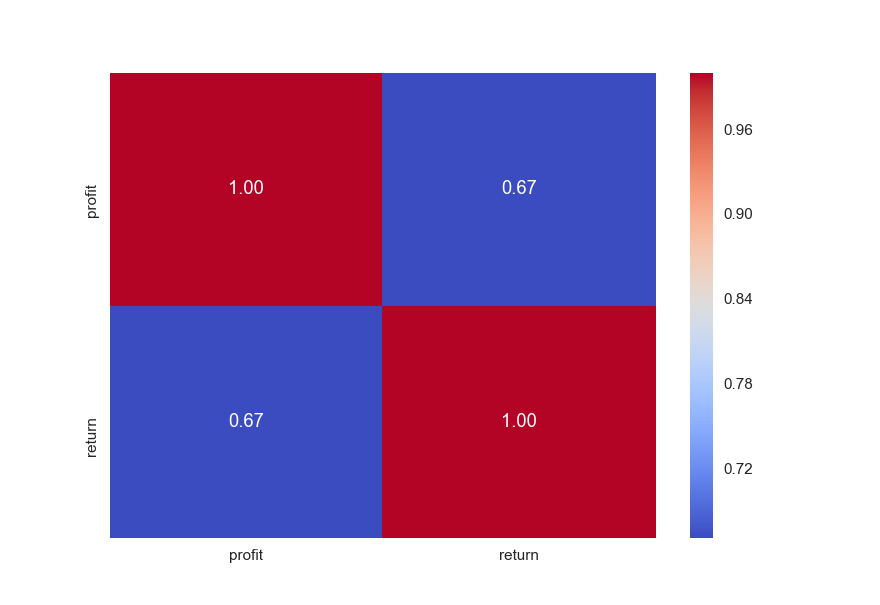

In [10]:
g1 = sns.heatmap(train[["profit","return" ]].corr(method='spearman'),annot=True, fmt = ".2f", cmap = "coolwarm")

In [77]:
feature_names = ["pf_category","start_date","country_code","euribor_rate", "currency", "libor_rate", "creation_date", "sell_date", "type", "profit"] 

In [78]:
temp_train['profit'] = (temp_train['sold'] - temp_train['bought']) / temp_train['bought']

In [81]:
def modelfit(model, train_data, train_label, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        params = {
            'objective' : xgb_param['objective'],
            'base_score' : xgb_param['base_score'],
            'colsample_bylevel' : xgb_param['colsample_bylevel'],
            'colsample_bytree' : xgb_param['colsample_bytree'],
            'gamma' : xgb_param['gamma'],
            'eta' : xgb_param['learning_rate'],
            'max_delta_step' : xgb_param['max_delta_step'],
            'max_depth' : xgb_param['max_depth'],
            'min_child_weight' : xgb_param['min_child_weight'],
            'alpha' : xgb_param['reg_alpha'],
            'lambda': xgb_param['reg_lambda'],
            'scale_pos_weight' : xgb_param['scale_pos_weight'],
            'subsample' : xgb_param['subsample'],     
        }
           
        dtrain = xgb.DMatrix(data=train_data[predictors], label=train_label)
        cvresult = xgb.cv(params , dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds, metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
        # print(cvresult)
        print("########### n_estimators = %f" % cvresult.shape[0])
    
    # Fit the algorithm on the data
    model.fit(train_data[predictors], train_label,eval_metric='rmse')
        
    # Predict training set:
    train_predictions = model.predict(train_data[predictors])
    #train_predprob = model.predict_proba(train_data[predictors])[:,1]
    
    # Predict X_valid set:
    #valid_predictions = model.predict(X_valid[predictors])
    #valid_predprob = model.predict_proba(X_valid[predictors])[:,1]
        
    # Print model report:
    print("\nModel Report")
    print("r2 score (Train): %.5g" % r2_score(train_label, train_predictions))
    # print("AUC Score (Train): %f" % roc_auc_score(train_label, train_predprob))
    #print("r2 score (Validation): %.5g" % r2_score(y_valid, valid_predictions))
    # print("AUC Score (Validation): %f" % roc_auc_score(y_valid, valid_predprob))
    
    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return model

In [30]:
clf1 = xgb.XGBClassifier(objective ='reg:linear',learning_rate=0.1, max_depth=4, n_estimators=1000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0)

In [34]:
clf1 = modelfit(clf1, temp_train, temp_train['return'], feature_names, early_stopping_rounds=100)

########### n_estimators = 63.000000

Model Report
r2 score (Train): 0.80774


ValueError: continuous is not supported

<IPython.core.display.Javascript object>


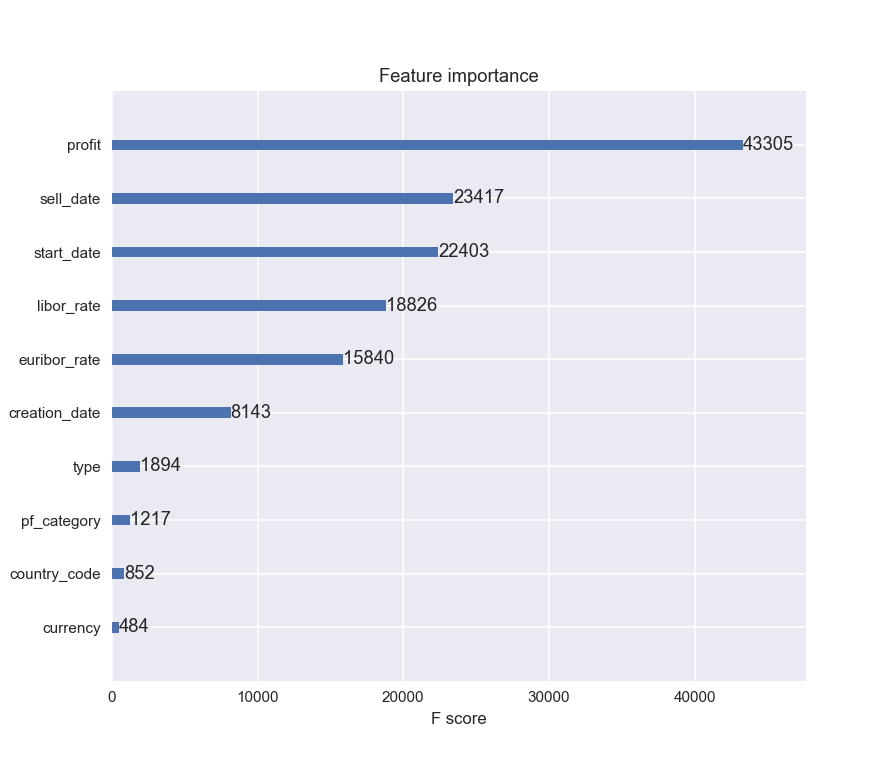

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001C18FFA07B8>>
Traceback (most recent call last):
  File "C:\Users\admin\Anaconda3\lib\site-packages\xgboost\core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001C18FF8E6A0>>
Traceback (most recent call last):
  File "C:\Users\admin\Anaconda3\lib\site-packages\xgboost\core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


In [35]:
xgb.plot_importance(clf1)

In [86]:
temp_test['profit'] = (temp_test['sold'] - temp_test['bought']) / temp_test['bought']

In [38]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['return'] = clf1.predict(temp_test[feature_names])
sub.to_csv('sub_xgb.csv', index=False)

In [13]:
sell_for_plot = train[['sell_date', 'return']].sort_values(by = ['sell_date'])

<IPython.core.display.Javascript object>


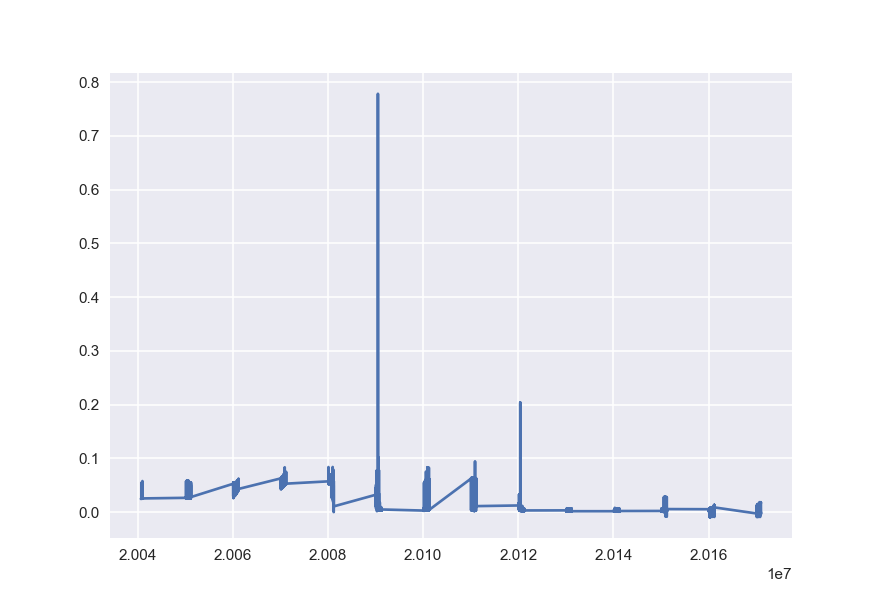

In [15]:
plt.plot(sell_for_plot['sell_date'], sell_for_plot['return'])

<IPython.core.display.Javascript object>


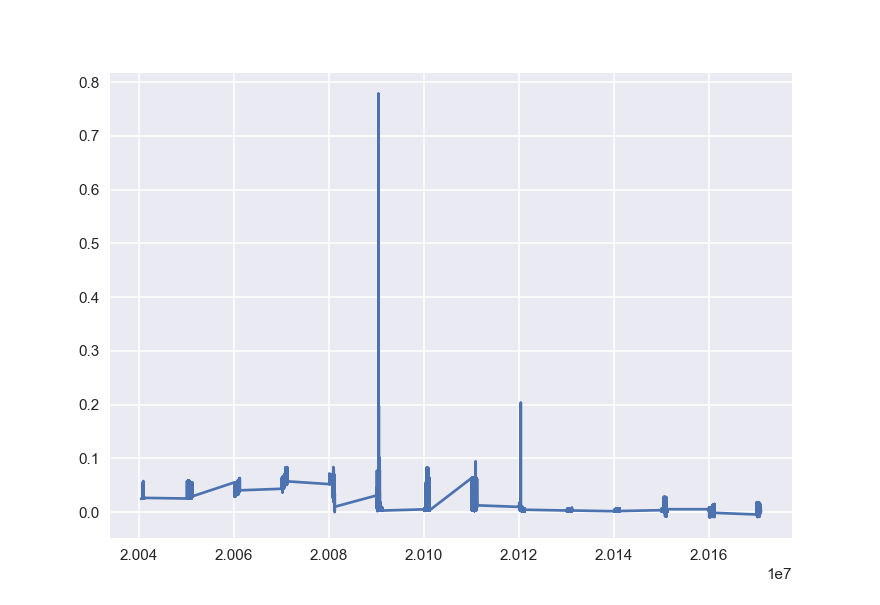

In [17]:
start_for_plot = train[['start_date', 'return']].sort_values(by = ['start_date'])
plt.plot(start_for_plot['start_date'], start_for_plot['return'])

<IPython.core.display.Javascript object>


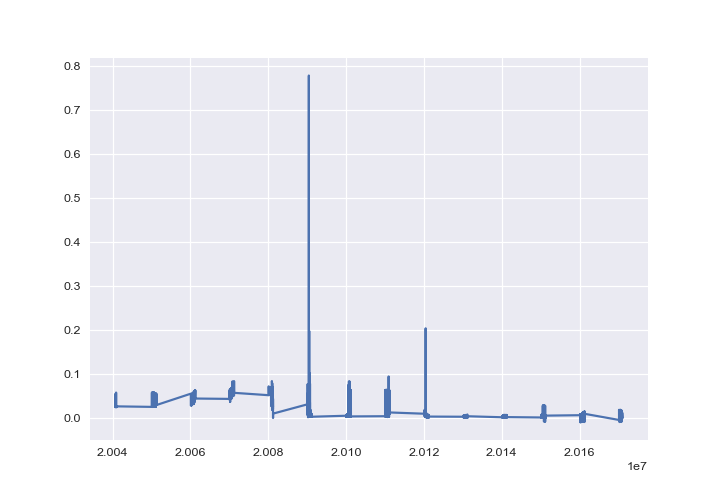

In [18]:
creation_for_plot = train[['creation_date', 'return']].sort_values(by = ['creation_date'])
plt.plot(creation_for_plot['creation_date'], creation_for_plot['return'])

In [20]:
train['sell_date'].max()

20171031

In [22]:
train['sell_date'].min()

20040713

In [23]:
test['sell_date'].max()

20171031

In [24]:
test['sell_date'].min()

20040709

In [52]:
train['start_date'].min()

20040414

In [27]:
len([x for x in test['sell_date'] if x not in train['sell_date']])

4801

<IPython.core.display.Javascript object>


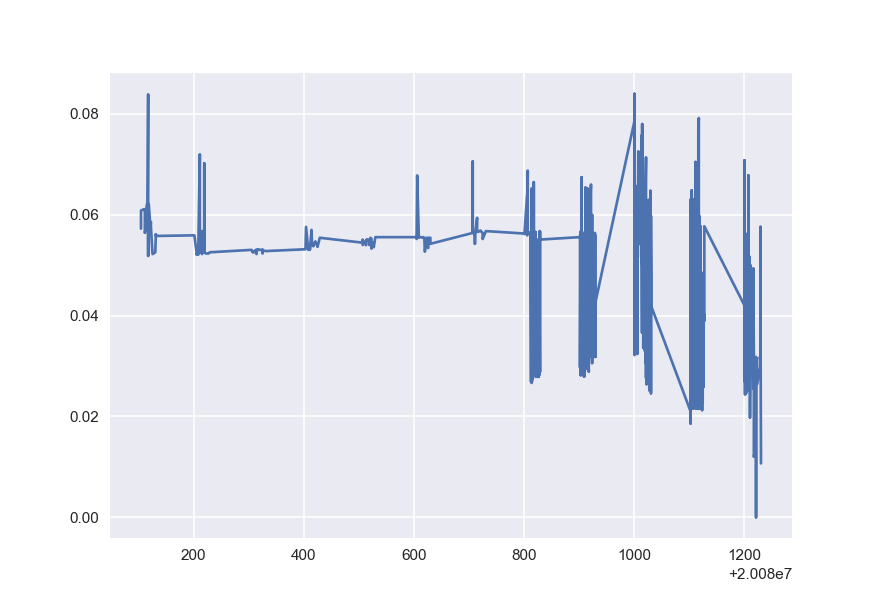

In [76]:
sell_for_plot = train[['sell_date', 'return']].sort_values(by = ['sell_date'])
sell_plot = sell_for_plot[(sell_for_plot['sell_date'] >= 20080101) & (sell_for_plot['sell_date'] <= 20081231)]
plt.plot(sell_plot['sell_date'], sell_plot['return'])

In [ ]:
8,10  2,3,4,5,6,7,8,9

<IPython.core.display.Javascript object>


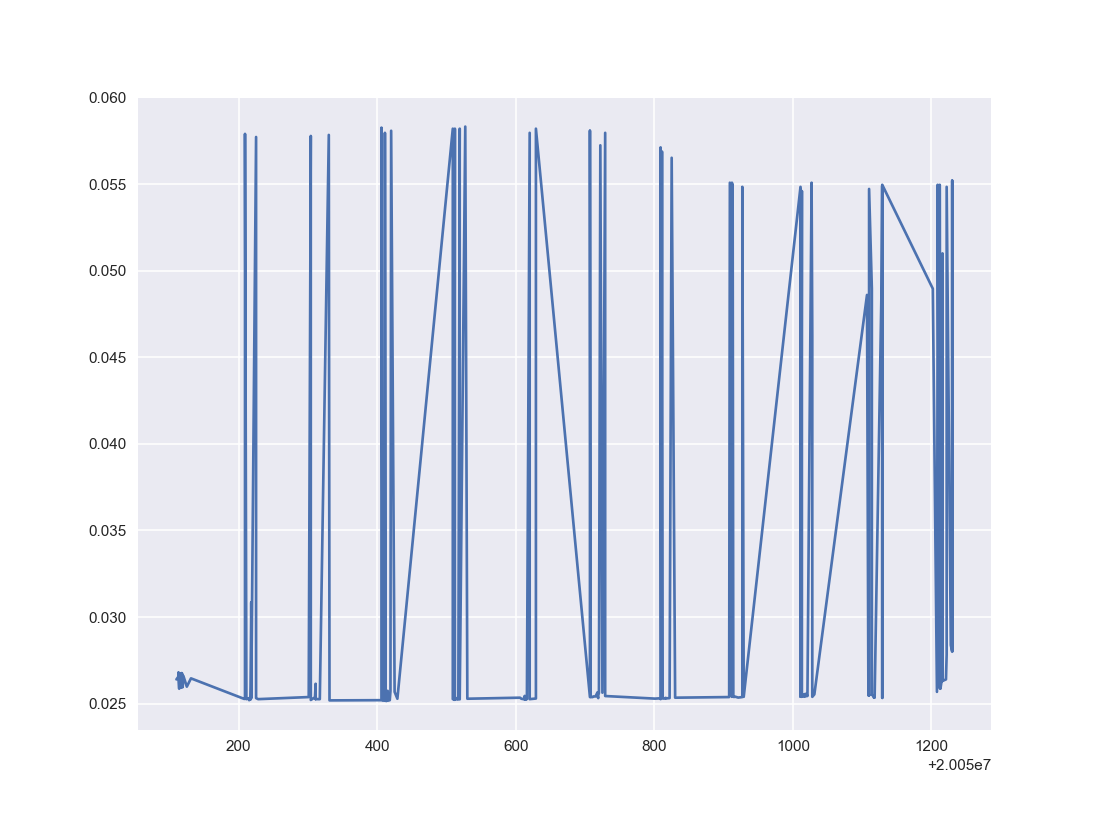

In [48]:
sell_for_plot = train[['sell_date', 'return']].sort_values(by = ['sell_date'])
sell_plot = sell_for_plot[(sell_for_plot['sell_date'] > 20050000) & (sell_for_plot['sell_date'] < 20060000)]
plt.plot(sell_plot['sell_date'], sell_plot['return'])

<IPython.core.display.Javascript object>


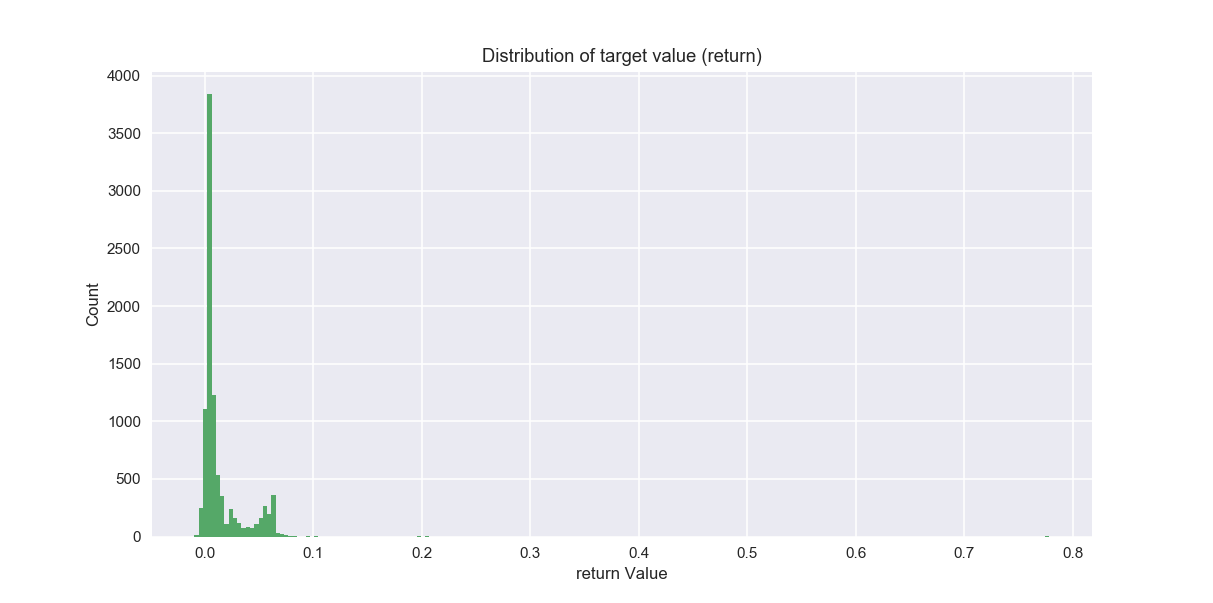

Target value min -0.010 max 0.778 mean 0.014 std 0.021


In [46]:
plt.hist(train['return'], bins=200, color=p[1])
plt.xlabel('return Value')
plt.ylabel('Count')
plt.title('Distribution of target value (return)')
print('Target value min {0:.3f} max {1:.3f} mean {2:.3f} std {3:.3f}'.format(np.min(train['return']), np.max(train['return']), np.mean(train['return']), np.std(train['return'])))

In [38]:
train[train['return'] > 0.1]

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return,profit
1665,PF00003547,DSK00003265,OFF00001002,C,20090422,59594739.68,M,0.01105,CHF,0.767045,59487353.18,20090422,NaN,20090512,E,NaN,NaN,0.778441,0.001805
1731,PF00003648,DSK00003360,OFF00001001,A,20090515,83461087.60,T,0.00931,USD,1.517774,83384651.67,20090515,NaN,20090520,A,NaN,NaN,0.198000,0.000917
1795,PF00003745,DSK00003447,OFF00001002,B,20090615,19922257.36,N,0.00933,GBP,1.739688,19908348.78,20090615,NaN,20090619,C,NaN,NaN,0.102000,0.000699
7096,PF00009234,DSK00006260,OFF00001001,A,20120424,13218700.00,T,0.00417,USD,0.948752,13200000.00,20120424,NaN,20120427,A,NaN,True,0.204000,0.001417


In [39]:
train[train['return'] <= 0.0]

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return,profit
1397,PF00003166,DSK00002934,OFF00001001,A,20081226,6.601944e+07,T,0.03523,USD,2.177120,6.601944e+07,20081226,NaN,20081222,A,NaN,NaN,0.000000,0.000000
7346,PF00015042,NaN,OFF00001002,B,20170306,3.300000e+07,T,-0.00161,USD,1.806910,3.301772e+07,20170306,True,20170608,B,False,True,-0.002520,-0.000537
7347,PF00015043,NaN,OFF00001001,A,20170306,4.400000e+07,T,-0.00161,USD,1.806910,4.403432e+07,20170306,True,20170606,A,False,True,-0.003660,-0.000779
7349,PF00015049,NaN,OFF00001002,B,20170308,2.200000e+07,T,-0.00161,USD,1.806910,2.200895e+07,20170307,True,20170509,B,False,True,-0.002880,-0.000407
7350,PF00015051,NaN,OFF00001002,B,20170308,1.100000e+07,T,-0.00161,USD,1.806910,1.100254e+07,20170307,True,20170410,B,False,True,-0.003120,-0.000231
7351,PF00015196,NaN,OFF00001002,B,20170420,8.690000e+07,T,-0.00151,USD,1.509442,8.692009e+07,20170418,True,20170522,B,False,True,-0.003120,-0.000231
7370,PF00013363,NaN,OFF00001002,B,20151021,3.300000e+07,U,-0.00113,JPY,0.236174,3.302058e+07,20151019,True,20151123,F,False,True,-0.008160,-0.000623
7374,PF00013984,NaN,OFF00001002,B,20160517,4.400000e+07,T,-0.00343,USD,1.094666,4.400568e+07,20160513,True,20160617,B,False,True,-0.001800,-0.000129
7381,PF00015609,NaN,OFF00001001,A,20170814,7.260000e+07,T,-0.00111,USD,1.650323,7.262314e+07,20170814,True,20170914,A,False,True,-0.004440,-0.000319
7385,PF00014306,NaN,OFF00001002,B,20160822,3.300000e+07,U,-0.00371,JPY,0.091876,3.302076e+07,20160818,True,20160922,F,False,True,-0.008760,-0.000629


In [40]:
train['hedge_value'].value_counts()

False    2437
True     1228
Name: hedge_value, dtype: int64

In [41]:
train[train['euribor_rate'] <= 0.0 ].shape[0]

1971

In [43]:
for column in train.columns:
    print("{0} : {1}".format(column, train[train['return'] <= 0.0][column].value_counts().count()))

portfolio_id : 337
desk_id : 1
office_id : 2
pf_category : 2
start_date : 213
sold : 113
country_code : 2
euribor_rate : 22
currency : 2
libor_rate : 37
bought : 324
creation_date : 215
indicator_code : 1
sell_date : 205
type : 3
hedge_value : 1
status : 1
return : 48
profit : 310


In [45]:
train[train['profit'] < 0.0].shape[0]

333

In [80]:
feature_names1 = ["country_code", "currency", "euribor_rate", "libor_rate", "sell_date", "type", "profit"] 

In [82]:
clf2 = xgb.XGBClassifier(objective ='reg:linear',learning_rate=0.1, max_depth=4, n_estimators=1000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0)

########### n_estimators = 70.000000

Model Report
r2 score (Train): 0.80908


<IPython.core.display.Javascript object>


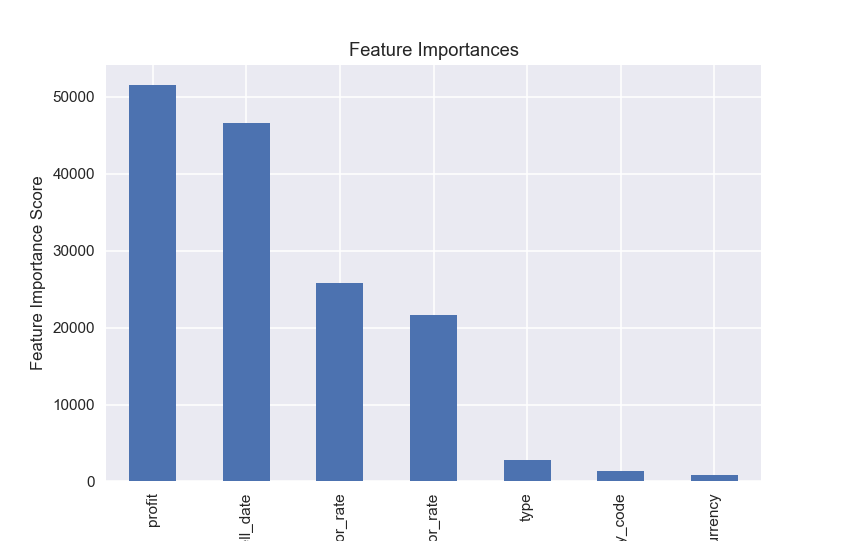

In [83]:
clf2 = modelfit(clf2, temp_train, temp_train['return'], feature_names1, early_stopping_rounds=100)

In [84]:
clf2.feature_importances_

array([ 0.00912187,  0.00548374,  0.1433873 ,  0.1710052 ,  0.30963904,
        0.01893419,  0.34242865], dtype=float32)

In [87]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['return'] = clf2.predict(temp_test[feature_names1])
sub.to_csv('sub_xgb1.csv', index=False)

In [90]:
temp_train_sorted = temp_train.sort_values(by= ['sell_date'])

<IPython.core.display.Javascript object>


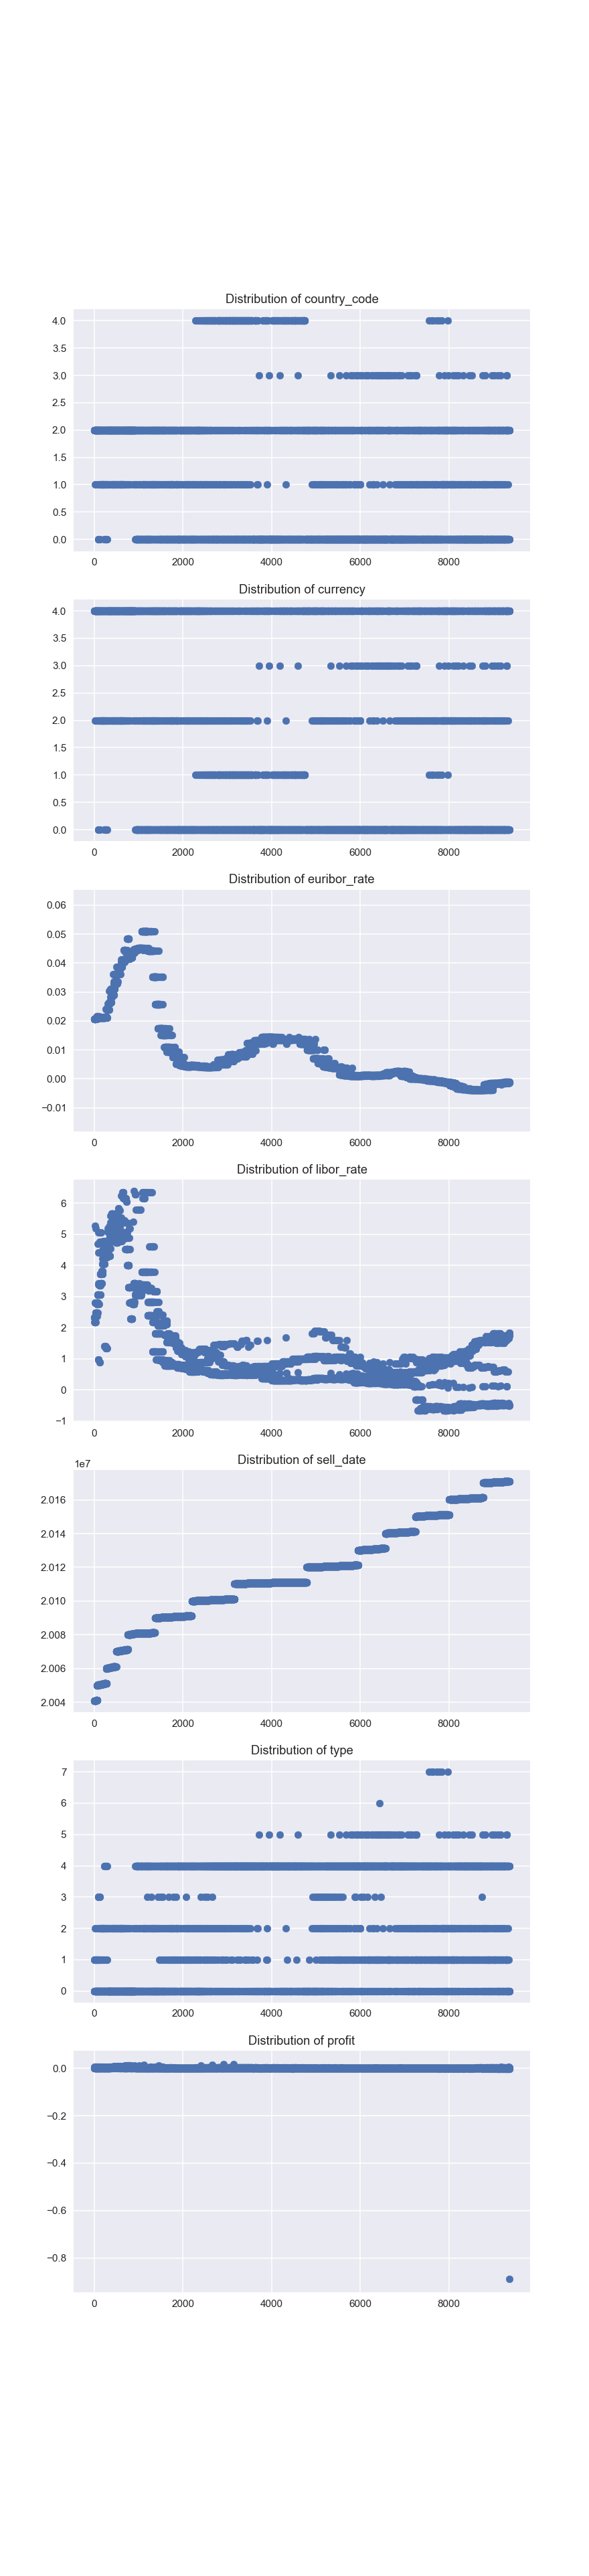

In [92]:
cols_to_use = ["country_code", "currency", "euribor_rate", "libor_rate", "sell_date", "type", "profit"] 
fig = plt.figure(figsize=(8, 35))
plot_count = 0
for col in cols_to_use:
    plot_count += 1
    plt.subplot(7, 1, plot_count)
    plt.scatter(range(temp_train_sorted.shape[0]), temp_train_sorted[col].values)
    plt.title("Distribution of "+col)
plt.show()

<IPython.core.display.Javascript object>


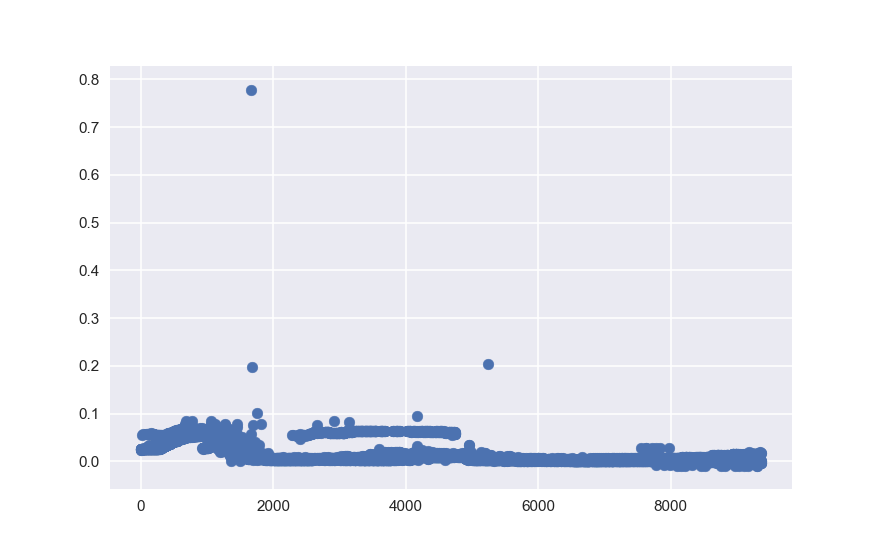

In [94]:
plt.figure(figsize=(8, 5))
plt.scatter(range(temp_train_sorted.shape[0]), temp_train_sorted['return'].values)
plt.show()

<IPython.core.display.Javascript object>


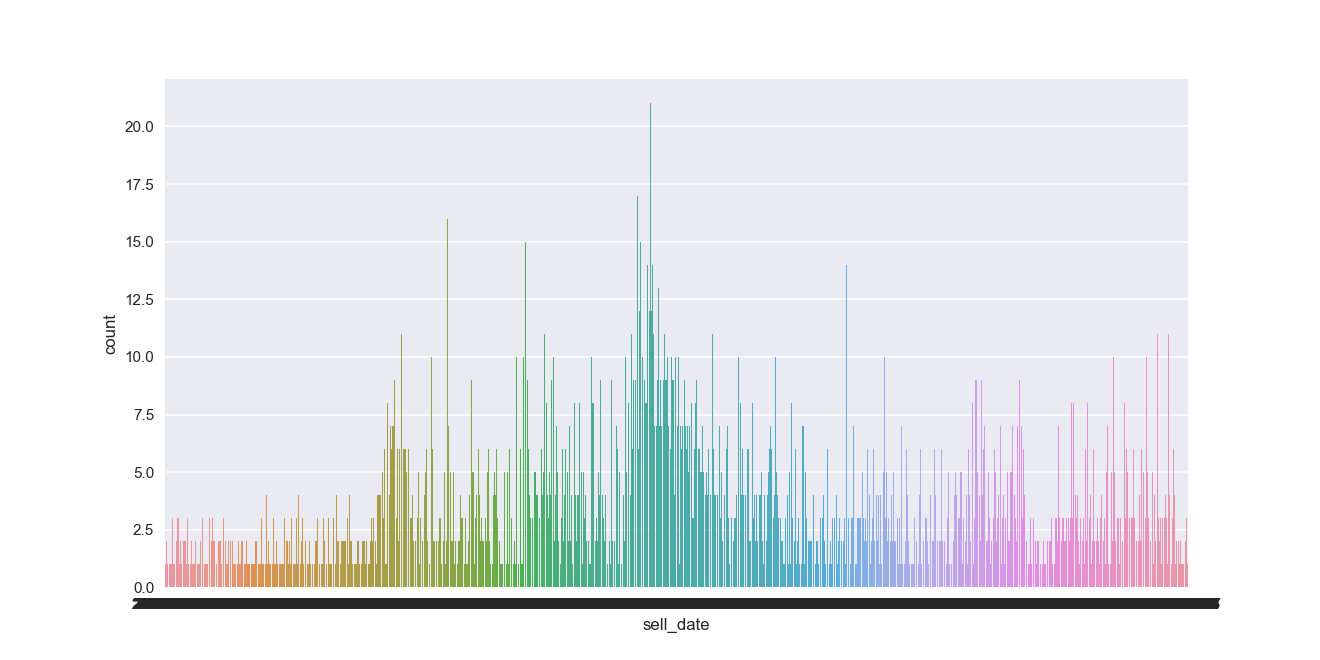

In [95]:
fig = plt.figure(figsize=(12, 6))
sns.countplot(x='sell_date', data=temp_train_sorted)
plt.show()

<IPython.core.display.Javascript object>


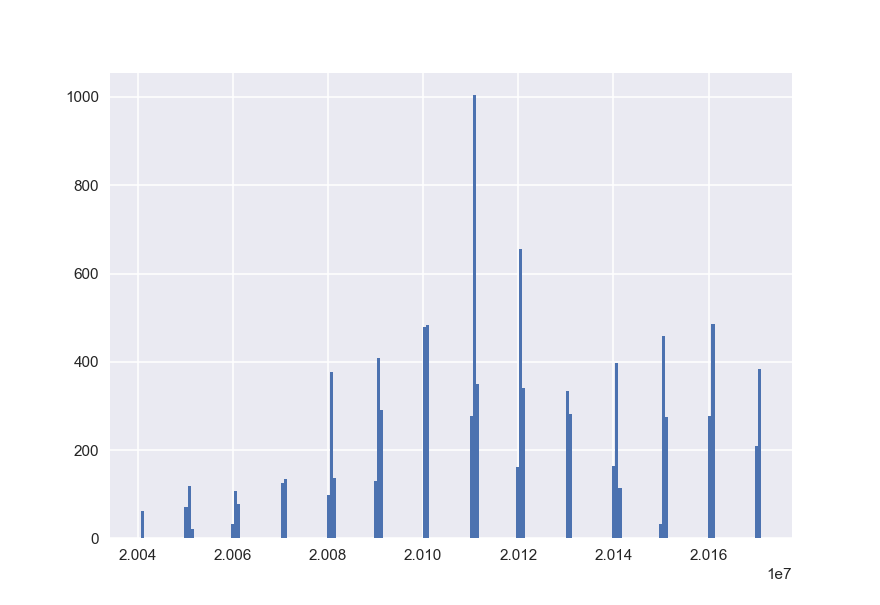

In [98]:
train['sell_date'].hist(bins=200)

In [99]:
market_df = temp_train_sorted[['sell_date', 'return']].groupby('sell_date').agg([np.mean, np.std, len]).reset_index()
market_df.head()

sell_date   return               
                mean       std  len
0  20040713  0.02486  0.000173  3.0
1  20040716  0.02502       NaN  1.0
2  20040720  0.02460       NaN  1.0
3  20040809  0.02493  0.000000  2.0
4  20040810  0.02490       NaN  1.0

In [100]:
market_df.isnull().sum(axis=0)

sell_date            0
return     mean      0
           std     622
           len       0
dtype: int64

In [103]:
market_df.shape

(2632, 4)

<IPython.core.display.Javascript object>


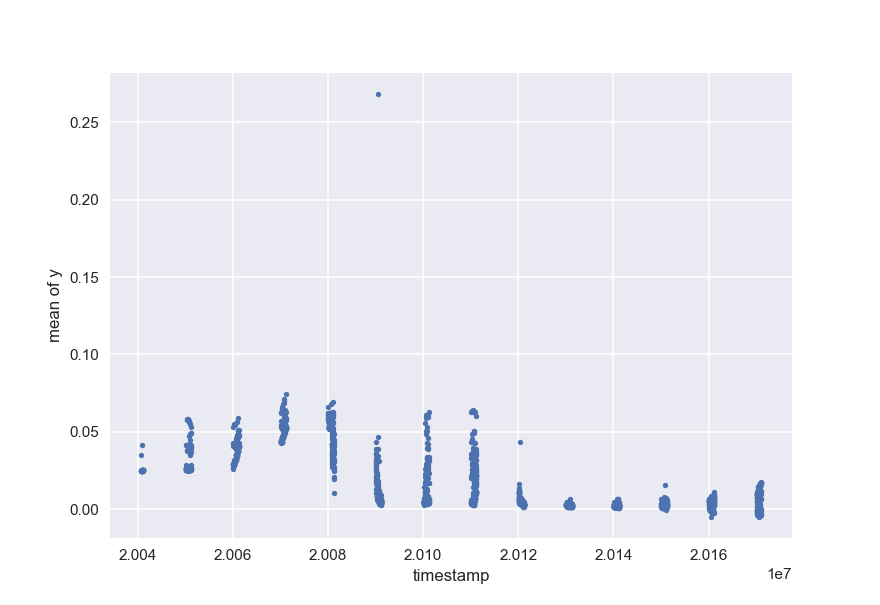

<IPython.core.display.Javascript object>


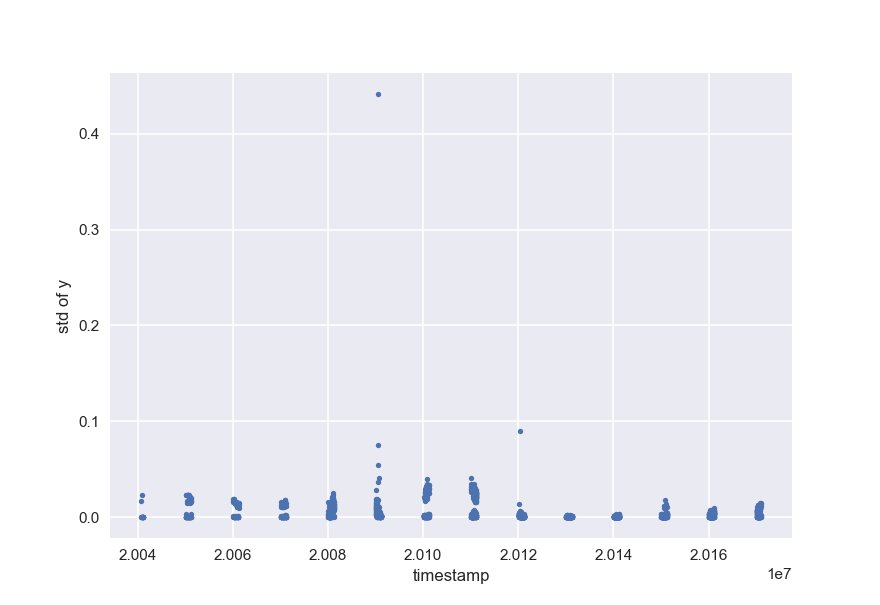

<IPython.core.display.Javascript object>


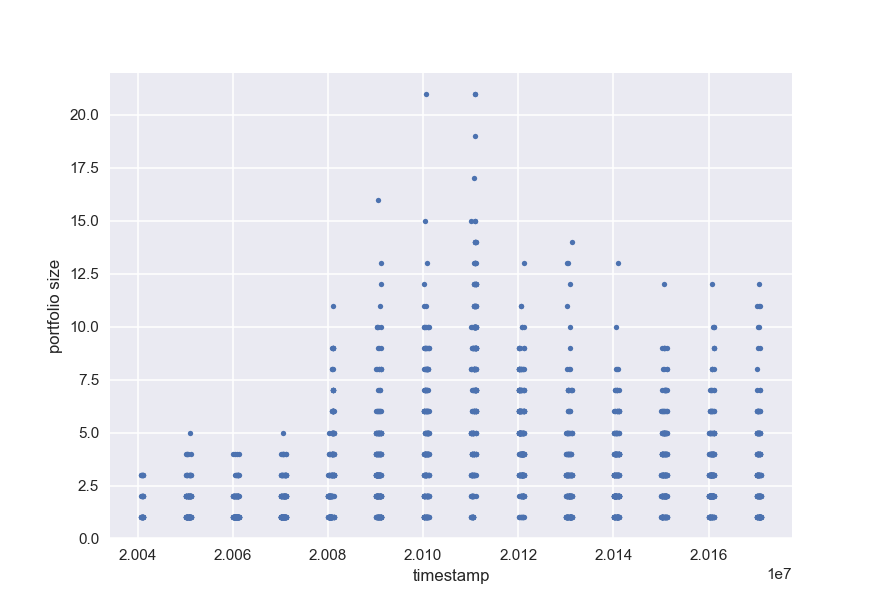

In [102]:
t      = market_df['sell_date']
y_mean = np.array(market_df['return']['mean'])
y_std  = np.array(market_df['return']['std'])
n      = np.array(market_df['return']['len'])

plt.figure()
plt.plot(t, y_mean, '.')
plt.xlabel('timestamp')
plt.ylabel('mean of y')

plt.figure()
plt.plot(t, y_std, '.')
plt.xlabel('timestamp')
plt.ylabel('std of y')

plt.figure()
plt.plot(t, n, '.')
plt.xlabel('timestamp')
plt.ylabel('portfolio size')